Question 1

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os

ROOT_DIR = "/content/drive/MyDrive/cs6886_mobilenet_sgd_clean"
os.makedirs(ROOT_DIR, exist_ok=True)

DATA_ROOT = os.path.join(ROOT_DIR, "data")
os.makedirs(DATA_ROOT, exist_ok=True)

CHECKPOINT_DIR = os.path.join(ROOT_DIR, "checkpoints")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

LOG_PATH = os.path.join(ROOT_DIR, "mobilenetv2_cifar10_sgd_logs.pt")

print("ROOT_DIR       :", ROOT_DIR)
print("DATA_ROOT      :", DATA_ROOT)
print("CHECKPOINT_DIR :", CHECKPOINT_DIR)
print("LOG_PATH       :", LOG_PATH)

Mounted at /content/drive
ROOT_DIR       : /content/drive/MyDrive/cs6886_mobilenet_sgd_clean
DATA_ROOT      : /content/drive/MyDrive/cs6886_mobilenet_sgd_clean/data
CHECKPOINT_DIR : /content/drive/MyDrive/cs6886_mobilenet_sgd_clean/checkpoints
LOG_PATH       : /content/drive/MyDrive/cs6886_mobilenet_sgd_clean/mobilenetv2_cifar10_sgd_logs.pt


In [2]:
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T
from torchvision.models.mobilenetv2 import MobileNetV2

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Device: cuda


In [3]:
def get_cifar10_loaders(data_root,
                        batch_size=64,
                        num_workers=2):
    cifar10_mean = (0.4914, 0.4822, 0.4465)
    cifar10_std  = (0.2023, 0.1994, 0.2010)

    train_transform = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(cifar10_mean, cifar10_std),
    ])

    test_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(cifar10_mean, cifar10_std),
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root=data_root,
        train=True,
        download=True,
        transform=train_transform
    )

    test_dataset = torchvision.datasets.CIFAR10(
        root=data_root,
        train=False,
        download=True,
        transform=test_transform
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_loader, test_loader

BATCH_SIZE = 64
train_loader, test_loader = get_cifar10_loaders(DATA_ROOT, batch_size=BATCH_SIZE)

images, labels = next(iter(train_loader))
print("Train batch:", images.shape, labels.shape)

Train batch: torch.Size([64, 3, 32, 32]) torch.Size([64])


In [4]:
class MobileNetV2CIFAR10(nn.Module):
    def __init__(self, width_mult=1.0, num_classes=10, dropout_p=0.2):
        super().__init__()
        self.mnet = MobileNetV2(width_mult=width_mult, num_classes=num_classes)

        # Adjust the first conv for 32x32 input (stride 1 instead of 2)
        first_conv_out_channels = int(32 * width_mult)
        first_conv = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=first_conv_out_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(first_conv_out_channels),
            nn.ReLU6(inplace=True),
        )
        self.mnet.features[0] = first_conv

        # Dropout + classifier
        last_channel = self.mnet.last_channel
        self.mnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(last_channel, num_classes),
        )

    def forward(self, x):
        return self.mnet(x)

model = MobileNetV2CIFAR10(width_mult=1.0, num_classes=10, dropout_p=0.2).to(device)
print("Model ready on", device)

Model ready on cuda


In [5]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

In [6]:
from torch.optim.lr_scheduler import MultiStepLR

num_epochs   = 200
base_lr      = 0.1
momentum     = 0.9
weight_decay = 5e-4
milestones   = [100, 150]
gamma        = 0.1

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    model.parameters(),
    lr=base_lr,
    momentum=momentum,
    weight_decay=weight_decay,
)

scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

print("Hyperparameters:")
print("  optimizer  = SGD+momentum")
print("  batch_size =", BATCH_SIZE)
print("  base_lr    =", base_lr)
print("  milestones =", milestones)

Hyperparameters:
  optimizer  = SGD+momentum
  batch_size = 64
  base_lr    = 0.1
  milestones = [100, 150]


In [ ]:
best_test_acc = 0.0
best_epoch = 0

train_losses, train_accs = [], []
test_losses, test_accs   = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss,  test_acc  = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    scheduler.step()

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc*100:5.2f}% | "
              f"Test Loss: {test_loss:.4f} Acc: {test_acc*100:5.2f}%")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_epoch = epoch + 1
        best_path = os.path.join(CHECKPOINT_DIR, "mobilenetv2_cifar10_sgd_best.pth")
        torch.save({
            "epoch": best_epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_losses": train_losses,
            "train_accs": train_accs,
            "test_losses": test_losses,
            "test_accs": test_accs,
            "best_test_acc": best_test_acc,
        }, best_path)

# Save logs
torch.save({
    "train_losses": train_losses,
    "train_accs": train_accs,
    "test_losses": test_losses,
    "test_accs": test_accs,
    "best_test_acc": best_test_acc,
    "best_epoch": best_epoch,
}, LOG_PATH)

print("Training finished.")
print(f"Best test accuracy: {best_test_acc*100:.2f}% at epoch {best_epoch}")
print("Logs saved to:", LOG_PATH)
print("Checkpoints in:", CHECKPOINT_DIR)

Epoch   1/200 Train Loss: 2.1156 Acc: 24.14% | Test Loss: 1.8146 Acc: 31.76%
Epoch  10/200 Train Loss: 0.9952 Acc: 65.58% | Test Loss: 1.1818 Acc: 59.84%
Epoch  20/200 Train Loss: 0.9485 Acc: 67.33% | Test Loss: 1.5565 Acc: 47.11%
Epoch  30/200 Train Loss: 0.9549 Acc: 67.10% | Test Loss: 1.0240 Acc: 64.49%
Epoch  40/200 Train Loss: 0.9710 Acc: 66.44% | Test Loss: 1.3619 Acc: 56.63%
Epoch  50/200 Train Loss: 0.9707 Acc: 66.57% | Test Loss: 1.2120 Acc: 56.95%
Epoch  60/200 Train Loss: 0.9813 Acc: 66.08% | Test Loss: 1.0616 Acc: 62.63%
Epoch  70/200 Train Loss: 0.9850 Acc: 66.25% | Test Loss: 1.0306 Acc: 65.25%
Epoch  80/200 Train Loss: 1.0007 Acc: 65.22% | Test Loss: 1.0629 Acc: 62.42%
Epoch  90/200 Train Loss: 1.0109 Acc: 65.02% | Test Loss: 1.2251 Acc: 57.63%
Epoch 100/200 Train Loss: 1.0123 Acc: 64.97% | Test Loss: 1.0505 Acc: 63.39%
Epoch 110/200 Train Loss: 0.6495 Acc: 77.57% | Test Loss: 0.6423 Acc: 77.66%
Epoch 120/200 Train Loss: 0.6512 Acc: 77.46% | Test Loss: 0.6269 Acc: 78.13%

In [ ]:
def smooth_curve(values, weight=0.9):
    """
    Exponential moving average smoothing.
    weight close to 1 = smoother curve.
    """
    smoothed = []
    last = values[0]
    for v in values:
        last = last * weight + (1 - weight) * v
        smoothed.append(last)
    return smoothed

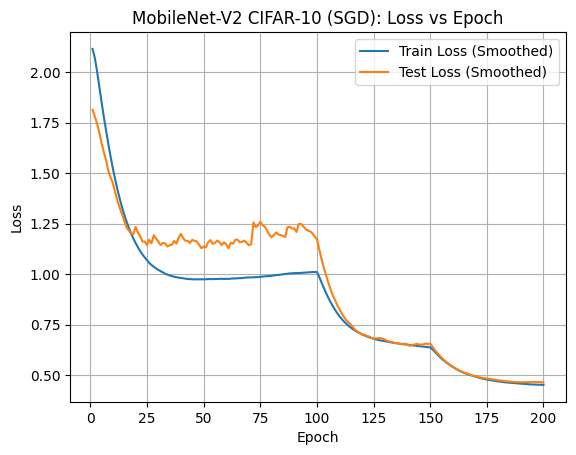

<Figure size 640x480 with 0 Axes>

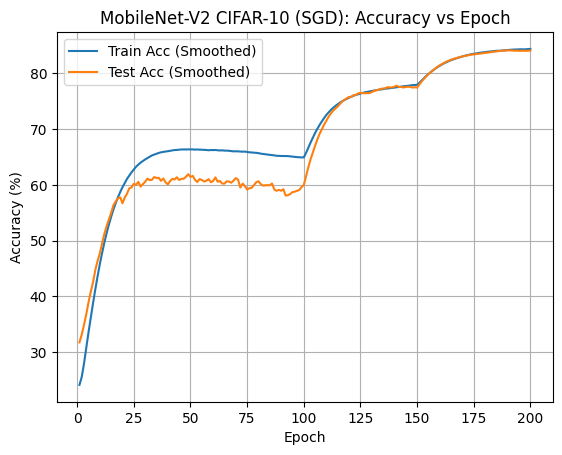

<Figure size 640x480 with 0 Axes>

Best test accuracy: 84.59 % at epoch 190
Loss curve saved to: /content/drive/MyDrive/cs6886_mobilenet_sgd_clean/mobilenetv2_cifar10_sgd_loss_curve.png
Accuracy curve saved to: /content/drive/MyDrive/cs6886_mobilenet_sgd_clean/mobilenetv2_cifar10_sgd_accuracy_curve.png


In [ ]:
logs = torch.load(LOG_PATH, map_location="cpu")
train_losses = logs["train_losses"]
train_accs   = logs["train_accs"]
test_losses  = logs["test_losses"]
test_accs    = logs["test_accs"]
best_test_acc = logs["best_test_acc"]
best_epoch = logs["best_epoch"]

epochs = range(1, len(train_losses) + 1)

plt.figure()
plt.plot(epochs, smooth_curve(train_losses), label="Train Loss (Smoothed)")
plt.plot(epochs, smooth_curve(test_losses), label="Test Loss (Smoothed)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNet-V2 CIFAR-10 (SGD): Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

loss_fig_path = os.path.join(ROOT_DIR, "mobilenetv2_cifar10_sgd_loss_curve.png")
plt.savefig(loss_fig_path, bbox_inches="tight")
plt.show()

plt.figure()
plt.plot(epochs, smooth_curve([a * 100 for a in train_accs]), label="Train Acc (Smoothed)")
plt.plot(epochs, smooth_curve([a * 100 for a in test_accs]), label="Test Acc (Smoothed)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("MobileNet-V2 CIFAR-10 (SGD): Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.show()

acc_fig_path = os.path.join(ROOT_DIR, "mobilenetv2_cifar10_sgd_accuracy_curve.png")
plt.savefig(acc_fig_path, bbox_inches="tight")
plt.show()

print("Best test accuracy:", best_test_acc * 100, "% at epoch", best_epoch)
print("Loss curve saved to:", loss_fig_path)
print("Accuracy curve saved to:", acc_fig_path)

Question 2

In [7]:
import copy
import math
import torch
import torch.nn as nn

from dataclasses import dataclass

@dataclass
class QuantConfig:
    weight_bits: int = 8          # bits for weights
    act_bits: int = 8             # bits for activations
    per_channel_weights: bool = True  # per-channel quant for conv weights
    symmetric: bool = True        # symmetric vs asymmetric quantization
    act_clip: float = 3.0         # clamp activations to [-act_clip, act_clip]

qconfig = QuantConfig(
    weight_bits=8,
    act_bits=8,
    per_channel_weights=True,
    symmetric=True,
    act_clip=3.0,
)

print(qconfig)

QuantConfig(weight_bits=8, act_bits=8, per_channel_weights=True, symmetric=True, act_clip=3.0)


In [8]:
def get_qrange(num_bits, symmetric=True):
    if symmetric:
        # e.g., int8 in [-127, 127]
        qmin = -(2 ** (num_bits - 1) - 1)
        qmax =  (2 ** (num_bits - 1) - 1)
    else:
        # e.g., uint8 in [0, 255]
        qmin = 0
        qmax = 2 ** num_bits - 1
    return qmin, qmax


def calc_qparams(t, num_bits, symmetric=True, eps=1e-8):
    """Compute scale and zero-point for a tensor t."""
    qmin, qmax = get_qrange(num_bits, symmetric)

    t_min = t.min().item()
    t_max = t.max().item()

    # avoid degenerate ranges
    if symmetric:
        max_val = max(abs(t_min), abs(t_max))
        scale = max_val / ((qmax - qmin) / 2.0 + eps)
        zero_point = 0
    else:
        scale = (t_max - t_min) / float(qmax - qmin + eps)
        zero_point = round(qmin - t_min / (scale + eps))

    scale = max(scale, eps)
    return float(scale), int(zero_point)


def quantize_tensor(t, num_bits, symmetric=True):
    """Quantize float tensor -> integer tensor, with scale & zero_point."""
    qmin, qmax = get_qrange(num_bits, symmetric)
    scale, zero_point = calc_qparams(t, num_bits, symmetric)

    q = t / scale + zero_point
    q = torch.round(q).clamp(qmin, qmax).to(torch.int8)  # int8 storage
    return q, scale, zero_point


def dequantize_tensor(q, scale, zero_point, symmetric=True):
    """Integer tensor -> float tensor using stored scale & zero_point."""
    return (q.float() - zero_point) * scale

In [9]:
def quantize_weights_per_tensor(w, num_bits, symmetric=True):
    """One scale & zero-point for the whole weight tensor."""
    q_w, scale, zp = quantize_tensor(w, num_bits=num_bits, symmetric=symmetric)
    return q_w, torch.tensor(scale), torch.tensor(zp)


def quantize_weights_per_channel(w, num_bits, symmetric=True, ch_axis=0):
    """
    Per-channel quantization along ch_axis (typically output channels).
    Returns:
      q_w: int8 tensor (same shape as w)
      scales: float tensor (num_channels,)
      zps: int tensor (num_channels,)
    """
    q_w = torch.empty_like(w, dtype=torch.int8)
    num_ch = w.shape[ch_axis]
    scales = torch.empty(num_ch, dtype=torch.float32)
    zps = torch.empty(num_ch, dtype=torch.int32)

    # move channel axis to dim 0 for easy iteration
    w_perm = w.permute(ch_axis, *[i for i in range(w.dim()) if i != ch_axis])
    q_perm = q_w.permute(ch_axis, *[i for i in range(w.dim()) if i != ch_axis])

    for c in range(num_ch):
        qw_c, sc_c, zp_c = quantize_tensor(w_perm[c], num_bits=num_bits, symmetric=symmetric)
        q_perm[c].copy_(qw_c)
        scales[c] = sc_c
        zps[c] = zp_c

    # permute back (in-place q_w already has correct layout)
    return q_w, scales, zps

In [10]:
def quantize_module_weights(module: nn.Module, qconfig: QuantConfig):
    """
    In-place weight quantization for Conv2d / Linear.
    - Adds buffers: weight_int, weight_scale, weight_zp
    - Leaves the original float weight in module.weight for now
    """
    if not isinstance(module, (nn.Conv2d, nn.Linear)):
        return

    w = module.weight.data.detach().cpu()

    if qconfig.per_channel_weights and isinstance(module, nn.Conv2d):
        q_w, scales, zps = quantize_weights_per_channel(
            w, num_bits=qconfig.weight_bits, symmetric=qconfig.symmetric, ch_axis=0
        )
    else:
        q_w, scale, zp = quantize_weights_per_tensor(
            w, num_bits=qconfig.weight_bits, symmetric=qconfig.symmetric
        )
        scales = torch.tensor([scale], dtype=torch.float32)
        zps = torch.tensor([zp], dtype=torch.int32)

    # register as buffers so they move with .to(device) and get saved in state_dict
    module.register_buffer("weight_int", q_w)
    module.register_buffer("weight_scale", scales)
    module.register_buffer("weight_zp", zps)

    print(f"Quantized weights for module: {module.__class__.__name__}, "
          f"shape={w.shape}, bits={qconfig.weight_bits}")

In [11]:
class QuantAct(nn.Module):
    """
    Quantize activations to a fixed bitwidth during forward.
    We use a simple symmetric scheme with clamping to [-act_clip, act_clip].
    """
    def __init__(self, num_bits=8, act_clip=3.0, symmetric=True):
        super().__init__()
        self.num_bits = num_bits
        self.act_clip = act_clip
        self.symmetric = symmetric

    def forward(self, x):
        # clamp activations to a fixed range
        x_clamped = x.clamp(-self.act_clip, self.act_clip)
        q, scale, zp = quantize_tensor(x_clamped, num_bits=self.num_bits, symmetric=self.symmetric)
        x_deq = dequantize_tensor(q, scale, zp, symmetric=self.symmetric)
        return x_deq

In [12]:
@torch.no_grad()
def evaluate_model(model, loader, device):
    model.eval()
    model.to(device)
    correct = 0
    total = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

In [13]:
import torch

ckpt_path = "/content/drive/MyDrive/cs6886_a3/checkpoints/checkpoint_epoch_190.pth"
print("Loading:", ckpt_path)

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])

baseline_test_loss, baseline_test_acc = evaluate_model(model, test_loader, device)
print(f"After loading checkpoint -> Test Loss: {baseline_test_loss:.4f}, "
      f"Test Acc: {baseline_test_acc*100:.2f}%")

Loading: /content/drive/MyDrive/cs6886_a3/checkpoints/checkpoint_epoch_190.pth
After loading checkpoint -> Test Loss: 0.3718, Test Acc: 87.51%


In [14]:
def compress_mobilenetv2(model: nn.Module, qconfig: QuantConfig):
    """
    Create a compressed copy of MobileNetV2:
      - Quantized weights for Conv2d and Linear
      - Activation quantization modules (QuantAct) inserted:
          * after each feature block (mnet.features[i])
          * before the classifier (on its input)
    """
    model_q = copy.deepcopy(model).cpu().eval()  # work on CPU copy in eval mode

    # 1. Quantize weights for all Conv2d and Linear layers (safe: only adds buffers)
    for _, m in model_q.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            quantize_module_weights(m, qconfig)

    # 2. Insert activation quantization modules
    #    We do this by rebuilding the relevant nn.Sequential containers
    #    to avoid modifying module dictionaries while iterating.

    # Case: your model wrapper has .mnet (MobileNetV2 from torchvision)
    if hasattr(model_q, "mnet") and isinstance(model_q.mnet, MobileNetV2):
        old_classifier = model_q.mnet.classifier
        new_classifier = nn.Sequential(
        QuantAct(
          num_bits=qconfig.act_bits,
          act_clip=qconfig.act_clip,
          symmetric=qconfig.symmetric,
        ),
        *list(old_classifier)
      )
        model_q.mnet.classifier = new_classifier

    else:
        # Fallback: we don't know the structure, so we only do weight quantization
        print("Warning: compress_mobilenetv2 did not detect MobileNetV2 structure; "
              "only weight quantization was applied (no activation QuantAct inserted).")

    print("Finished building compressed MobileNetV2 (weights + activations).")
    return model_q

# Example usage (assuming `model` is your trained baseline on GPU):
model_cpu = model.cpu().eval()
compressed_model = compress_mobilenetv2(model_cpu, qconfig)

Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.S

In [15]:
compressed_test_loss, compressed_test_acc = evaluate_model(
    compressed_model, test_loader, device
)
print(f"Compressed model -> Test Loss: {compressed_test_loss:.4f}, "
      f"Test Acc: {compressed_test_acc*100:.2f}%")

Compressed model -> Test Loss: 0.3719, Test Acc: 87.49%


Question 3

In [16]:
import math
import torch.nn as nn

def estimate_model_size_bytes(model: nn.Module, qconfig: QuantConfig):
    """
    Estimate baseline FP32 size and compressed size (weights int + metadata + BN).
    Returns (baseline_bytes, compressed_bytes, compression_ratio).
    """
    # Baseline: all parameters as FP32
    total_params = sum(p.numel() for p in model.parameters())
    baseline_bytes = total_params * 4  # 4 bytes per FP32

    # For compressed size, count:
    #  - Conv/Linear weights as weight_bits
    #  - BN params/buffers still FP32
    #  - Scales + zero-points metadata
    convlin_weight_elems = 0
    bn_fp32_elems = 0
    scale_elems = 0

    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            w = m.weight
            convlin_weight_elems += w.numel()

            if isinstance(m, nn.Conv2d) and qconfig.per_channel_weights:
                out_ch = w.shape[0]
                scale_elems += out_ch      # per-channel scales / zps
            else:
                scale_elems += 1           # per-tensor scale / zp

        elif isinstance(m, nn.BatchNorm2d):
            # count FP32 BN params + buffers
            for _, t in list(m.named_parameters()) + list(m.named_buffers()):
                if t.dtype == torch.float32:
                    bn_fp32_elems += t.numel()

    compressed_weight_bytes = convlin_weight_elems * (qconfig.weight_bits / 8.0)
    scale_bytes = scale_elems * 4      # FP32 scales
    zp_bytes = scale_elems * 4         # int32 zero-points
    bn_bytes = bn_fp32_elems * 4       # FP32 BN stats + params

    compressed_bytes = compressed_weight_bytes + scale_bytes + zp_bytes + bn_bytes
    compression_ratio = baseline_bytes / compressed_bytes

    return baseline_bytes, compressed_bytes, compression_ratio

In [17]:
!pip install -q wandb

import wandb

# Login (one-time, will prompt in Colab)
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ee24d032 (ee24d032-iitm-india) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [18]:
def run_single_config(cfg: QuantConfig, run_name: str, project: str = "cs6886_mobilenet_quant"):
    # Evaluate baseline size from full-precision model
    baseline_bytes, compressed_bytes, compression_ratio = estimate_model_size_bytes(model, cfg)
    baseline_mb = baseline_bytes / (1024 * 1024)
    compressed_mb = compressed_bytes / (1024 * 1024)

    # Build compressed model and evaluate
    model_cpu = model.cpu().eval()
    compressed_model = compress_mobilenetv2(model_cpu, cfg)
    test_loss, test_acc = evaluate_model(compressed_model, test_loader, device)

    # Start a new W&B run for this config
    run = wandb.init(project=project, name=run_name, config={
        "weight_bits": cfg.weight_bits,
        "act_bits": cfg.act_bits,
        "per_channel_weights": cfg.per_channel_weights,
        "symmetric": cfg.symmetric,
        "act_clip": cfg.act_clip,
    })

    wandb.log({
        "baseline_size_mb": baseline_mb,
        "compressed_size_mb": compressed_mb,
        "compression_ratio": compression_ratio,
        "quantized_acc": test_acc * 100.0,
        # optional extra axes if you want them in the parallel plot
        "weight_quant_bits": cfg.weight_bits,
        "activation_quant_bits": cfg.act_bits,
    })

    print(f"[{run_name}] acc={test_acc*100:.2f}%  size={compressed_mb:.2f}MB  "
          f"ratio={compression_ratio:.2f}x")

    run.finish()

    return {
        "cfg": cfg,
        "acc": test_acc,
        "compressed_mb": compressed_mb,
        "compression_ratio": compression_ratio,
    }

In [19]:
configs = [
    QuantConfig(weight_bits=8, act_bits=8, per_channel_weights=True,  symmetric=True, act_clip=3.0),
    QuantConfig(weight_bits=6, act_bits=8, per_channel_weights=True,  symmetric=True, act_clip=3.0),
    QuantConfig(weight_bits=6, act_bits=6, per_channel_weights=True,  symmetric=True, act_clip=3.0),
    QuantConfig(weight_bits=4, act_bits=8, per_channel_weights=True,  symmetric=True, act_clip=3.0),
    QuantConfig(weight_bits=4, act_bits=6, per_channel_weights=True,  symmetric=True, act_clip=3.0),
    QuantConfig(weight_bits=4, act_bits=4, per_channel_weights=True,  symmetric=True, act_clip=3.0),
    QuantConfig(weight_bits=8, act_bits=4, per_channel_weights=True,  symmetric=True, act_clip=3.0),
    QuantConfig(weight_bits=8, act_bits=8, per_channel_weights=False, symmetric=True, act_clip=3.0),
]

In [20]:
results = []

for i, cfg in enumerate(configs):
    run_name = f"quant_cfg_{i}_w{cfg.weight_bits}_a{cfg.act_bits}_" \
               f"pc{int(cfg.per_channel_weights)}"
    res = run_single_config(cfg, run_name)
    results.append(res)

# Quick local summary
for r in results:
    cfg = r["cfg"]
    print(f"w_bits={cfg.weight_bits}, a_bits={cfg.act_bits}, "
          f"per_ch={cfg.per_channel_weights} -> "
          f"acc={r['acc']*100:.2f}%, "
          f"size={r['compressed_mb']:.2f}MB, "
          f"ratio={r['compression_ratio']:.2f}x")

Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_0_w8_a8_pc1] acc=87.49%  size=2.49MB  ratio=3.43x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,8
baseline_size_mb,8.53226
compressed_size_mb,2.49091
compression_ratio,3.42536
quantized_acc,87.49


Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_1_w6_a8_pc1] acc=87.49%  size=1.97MB  ratio=4.34x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,8
baseline_size_mb,8.53226
compressed_size_mb,1.96578
compression_ratio,4.34039
quantized_acc,87.49


Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=6
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=6
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_2_w6_a6_pc1] acc=87.56%  size=1.97MB  ratio=4.34x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,6
baseline_size_mb,8.53226
compressed_size_mb,1.96578
compression_ratio,4.34039
quantized_acc,87.56


Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_3_w4_a8_pc1] acc=87.49%  size=1.44MB  ratio=5.92x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,8
baseline_size_mb,8.53226
compressed_size_mb,1.44065
compression_ratio,5.92251
quantized_acc,87.49


Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_4_w4_a6_pc1] acc=87.56%  size=1.44MB  ratio=5.92x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,6
baseline_size_mb,8.53226
compressed_size_mb,1.44065
compression_ratio,5.92251
quantized_acc,87.56


Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=4
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=4
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_5_w4_a4_pc1] acc=87.57%  size=1.44MB  ratio=5.92x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,4
baseline_size_mb,8.53226
compressed_size_mb,1.44065
compression_ratio,5.92251
quantized_acc,87.57


Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_6_w8_a4_pc1] acc=87.57%  size=2.49MB  ratio=3.43x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,4
baseline_size_mb,8.53226
compressed_size_mb,2.49091
compression_ratio,3.42536
quantized_acc,87.57


Quantized weights for module: Conv2d, shape=torch.Size([32, 3, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([16, 32, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 16, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([96, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 96, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([24, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 24, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([144, 1, 3, 3]), bits=8
Quantized weights for module: Conv2d, shape=torch.Size([32, 144, 1, 1]), bits=8
Quantized weights for module: Conv2d, shape=torch.S

[quant_cfg_7_w8_a8_pc0] acc=87.49%  size=2.36MB  ratio=3.61x


activation_quant_bits,▁
baseline_size_mb,▁
compressed_size_mb,▁
compression_ratio,▁
quantized_acc,▁
weight_quant_bits,▁
activation_quant_bits,8
baseline_size_mb,8.53226
compressed_size_mb,2.36118
compression_ratio,3.61355
quantized_acc,87.49


w_bits=8, a_bits=8, per_ch=True -> acc=87.49%, size=2.49MB, ratio=3.43x
w_bits=6, a_bits=8, per_ch=True -> acc=87.49%, size=1.97MB, ratio=4.34x
w_bits=6, a_bits=6, per_ch=True -> acc=87.56%, size=1.97MB, ratio=4.34x
w_bits=4, a_bits=8, per_ch=True -> acc=87.49%, size=1.44MB, ratio=5.92x
w_bits=4, a_bits=6, per_ch=True -> acc=87.56%, size=1.44MB, ratio=5.92x
w_bits=4, a_bits=4, per_ch=True -> acc=87.57%, size=1.44MB, ratio=5.92x
w_bits=8, a_bits=4, per_ch=True -> acc=87.57%, size=2.49MB, ratio=3.43x
w_bits=8, a_bits=8, per_ch=False -> acc=87.49%, size=2.36MB, ratio=3.61x
